# Scenario Discovery

This notebook takes the output from our initial set of experiments to assess how the model's outcomes are affected by various levels of the model's uncertainties. It uses the patient rule-induction method (PRIM) to find a bounding subspace of the uncertainty space, effectively defining the "subspace of concern": a region of the uncertainty space that is likely to produce "bad" results, according to our client's goals.

First, we will filter out some less-relevant results, and visually inspect those that remain for insight. Then, we will run the PRIM algorithm to discover such a subspace and analyse the meaning of its boundaries. Finally, we will save the subset of generated scenarios from the original experiments that fall within this subspace; this will be used in the [scenario diversiy scoring](open_exploration__scenario_diversity_scoring.py) file to select a diverse set of four such scenarios of concern under which we can search for optimal policies. 

-------------------
## 0. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting, prim

We will use the results from our base case experiments, where we ran the base case (i.e. the status quo, no policy) under 100000 scenarios sampled by the ema_workbench's Latin Hypercube sampler.

In [2]:
input_filename = './output/vulnerability_results__3933_scenarios'
results = load_results(input_filename + '.tar.gz')

In [3]:
experiments, outcomes = results
experiments.shape

(15732, 53)

In [4]:
for pol in np.unique(experiments.policy):
    print(experiments[experiments.policy == pol].shape[0])

3933
3933
3933
3933


In [5]:
experiments.head()

,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,...,A3_DikeIncrease_t2,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,A5_DikeIncrease_t2,scenario,policy,model
0,245.492589,0.730879,1.5,103.700541,0.811144,1.5,212.666805,0.966618,1.5,51.327441,...,0,10,7,0,5,0,0,0,s91325_p86,dikesnet
1,262.554875,0.969102,10.0,280.377067,0.526979,10.0,187.570341,0.696104,1.0,64.726114,...,0,10,7,0,5,0,0,1,s91325_p86,dikesnet
2,275.708351,0.572317,1.0,265.693511,0.420025,1.5,121.947334,0.759597,10.0,272.023678,...,0,10,7,0,5,0,0,2,s91325_p86,dikesnet
3,62.466739,0.880597,1.5,136.376759,0.461343,1.5,142.623248,0.675062,10.0,203.202055,...,0,10,7,0,5,0,0,3,s91325_p86,dikesnet
4,262.062862,0.563094,10.0,193.450856,0.674911,10.0,273.473465,0.496738,1.5,291.804449,...,0,10,7,0,5,0,0,4,s91325_p86,dikesnet


---------------------------------------

## 1. Visual Analysis

Before running PRIM, we can gain some insights into the how the scenarios we ran ranged in our outcome space. Since PRIM uses a binary classification of experiments based on outcomes, understanding what contributes to an experiment resulting in a "bad case" is an important part of this process.

In our case, "A4_Expected_Annual_Damage" is the outcome of maximum interest. It is the more concrete of the two metrics affect our Client's region. We will study the distributions of our results across all 5 scenarios of interest, and in this process we will identify and store the performance threshold by which we will classify experiments as failures or successes for PRIM.

In [7]:
outcomes_of_interest = ['A4_Expected_Annual_Damage', 'A4_Expected_Number_of_Deaths',
                        'Total_Expected_Annual_Damage', 'Total_Expected_Number_of_Deaths']
ooi = outcomes_of_interest[0]

In [10]:
sns.set_style('darkgrid')

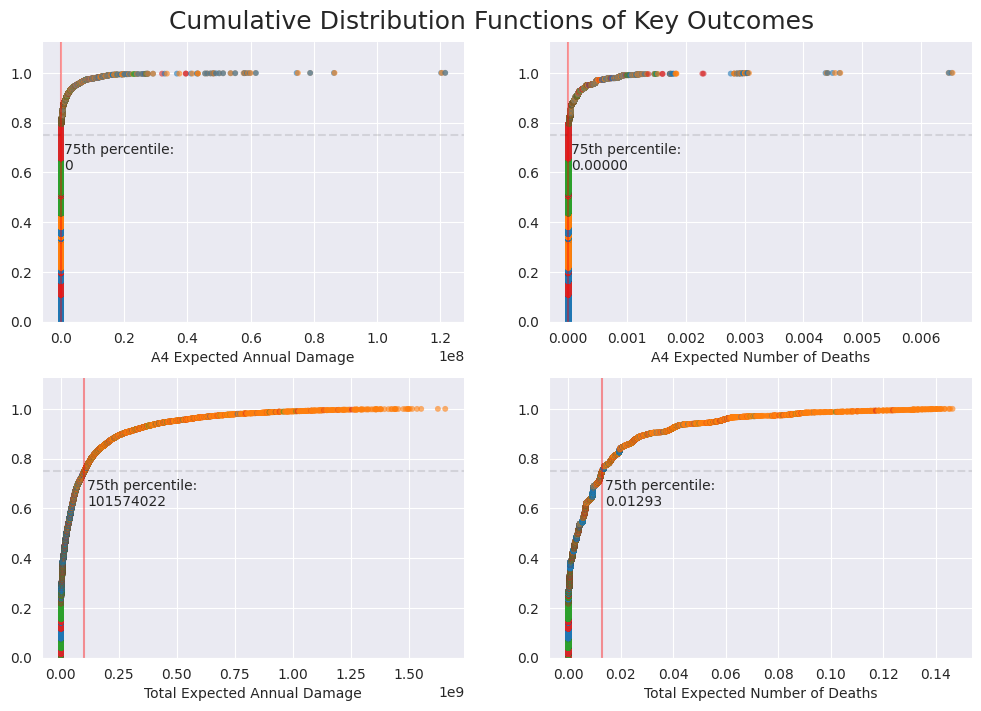

In [11]:
N = experiments.shape[0]
performance_threshold = None

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(outcomes_of_interest, axs.ravel()):
    # Build data for plotting
    df = pd.DataFrame()
    df[col] = outcomes[col]
    df['policy'] = experiments['policy']
    df = df.sort_values(by=col, ascending=True)
    df['y'] = np.arange(N)/N
    df = df.reset_index()
    
    # Plot
    sns.scatterplot(data=df, x=col, y='y', hue='policy',
                    legend=False, size=1, linewidth=0,
                    alpha=0.6, palette='tab10', ax=ax)

    # Plot line at 75th percentile
    median = int(N*0.75)
    ax.axhline(median/N, color='k', alpha=0.1, ls='--')
    ax.axvline(df[col][median], label=str(df[col][median]),
               color='r', alpha=0.4)
    
    # Label line with 75th percentile value
    annotation_point = int(N*0.61)/N # tested to line up with a gridline
    if col.split('_')[-1] == 'Deaths':
        ax.annotate(text=f"75th percentile:\n{df[col][median]:.5f}", 
                    xy=(df[col][median], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    else:
        ax.annotate(text=f"75th percentile:\n{df[col][median]:.0f}", 
                    xy=(df[col][median], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    
    # Save performance threshold (75th percentile of outcome of interest)
    if (col == ooi):
        performance_threshold = df[col][median]

    # Set up graph
    sns.despine(ax=ax)
    col_name = ' '.join(col.split('_'))
    ax.set(xlabel=col_name, ylabel=None, ylim=[0, 1.125])

plt.suptitle(f'Cumulative Distribution Functions of Key Outcomes',
             fontsize=18, y=0.92)
plt.savefig(f'img/vulnerability__CDFs.png')
plt.show()

These graphs confirm what we conjectured based on the pairplots: though with some exceptions, these outcome values are generally exponential distributions, with the majority of the results being condensed at the lower values and a few results being spread across a long tail of extreme values. This further corroborates our guess that it takes the confluence of _multiple_ "bad" uncertainties to create a scenario of extreme "bad" outcome; if there were just one or two key, dominant uncertainties, since each gets sampled from a uniform distribution, these CDFs might look more linear.

It is of note that the "Total" outcomes are somewhat more sharply exponential than the Dike Ring 4 outcomes (in these plots, you can see this as the 90th percentile point being further to the left). 

-----------------------------------

## 2. Scenario Discovery -- Subspace Discovery with PRIM

We now move to the more interesting analysis of these results. We can use PRIM, described in the introduction of this notebook, to identify a subspace in the uncertainty space that could be adequately described as a "region of concern," i.e., limits on the uncertainty boundaries where we expect a scenario that falls within those limits to result in a bad outcome. We define a "bad outcome" as one that fails according to the performance threshold defined above: equal to or worse than the 90th percentile 'A4 Expected Annual Damage' result from the filtered subset of the 100,000 scenario run.

First, we will set up the PRIM algorithm. We'll give it our input data and tell it to apply the correct performance threshold to our outcomes. We'll also provide some simple parameters to the algorithm, defining the minimum acceptable density of the final box in PRIM's search and the minimum mass a box along its search can have. 

(NB: "density" here refers to the fraction of the cases in the box that are of concern. "mass" refers to the fraction of total cases that fall in the box).

In [12]:
uncertainties = ['A0_ID_flood_wave_shape', 'A1_Bmax', 'A1_Brate', 'A1_pfail', 'A2_Bmax',
                 'A2_Brate', 'A2_pfail', 'A3_Bmax', 'A3_Brate', 'A3_pfail', 'A4_Bmax',
                 'A4_Brate', 'A4_pfail', 'A5_Bmax', 'A5_Brate', 'A5_pfail',
                 'discount_rate_0', 'discount_rate_1', 'discount_rate_2',]

In [13]:
prim_alg = prim.setup_prim(results,
                           classify=lambda y: y[ooi] > performance_threshold,
                           threshold=0.75,
                           incl_unc=uncertainties,
                           mass_min=0.01
                           )

# Run PRIM search algorithm once
box1 = prim_alg.find_box()

We can use the EMA Workbench to plot all the boxes found along PRIM's search, plotted by their _density_ (defined above) and _coverage_ (defined in contrast as the fraction of cases of concern that fall within the box). Both metrics are important in our case: we care about coverage because we want to be able to describe as many scenarios of concern as possible, while we care about density because we want to ensure we aren't casting too wide a net when defining this space to the point that we also include an excessive number of scenarios of no concern. Thus, we will draw lines at 75% for each of them, to see if PRIM can find a box that performs well in both regards.

In [14]:
sns.set_style('whitegrid')

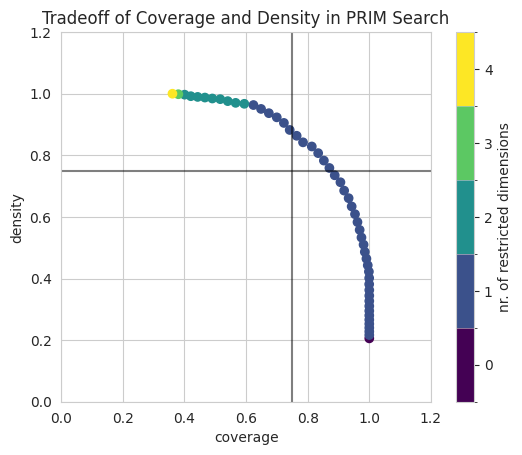

In [15]:
box1.show_tradeoff()

plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='k', alpha=0.5)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='k', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search')
plt.savefig('img/vulnerability__prim_trajectory.png')
plt.show()

It looks like PRIM discovered one or two boxes that satisfy by having both a decent coverage and density. We can inspect numerically:

In [16]:
candidates = box1.peeling_trajectory
candidates = candidates[(candidates.coverage > 0.75)
                         & (candidates.density > 0.75)]
candidates

,coverage,density,id,mass,mean,res_dim
28,0.870519,0.758890,28,0.235952,0.758890,1
29,0.852596,0.782917,29,0.224002,0.782917,1
30,0.834054,0.807117,30,0.212560,0.807117,1
31,0.813350,0.828715,31,0.201882,0.828715,1
32,0.784920,0.842175,32,0.191711,0.842175,1
33,0.764215,0.863478,33,0.182049,0.863478,1


Indeed, there are two candidate boxes that beat 75% in both metrics. Both restrict the uncertainty space in 4 dimensions (likely the same 4 dimensions), sso we will choose **the one with higher density**. As described previously, once coverage is satisfied (our goal was 75%), density is important to ensure that we limit false positives.

In [17]:
best_box = candidates[candidates.density
                      == candidates.density.max()]
best_box_idx = int(best_box.index[0])

box1.select(best_box_idx)
best_box_idx

33

In the next cell, we will look at how this bounding box restricts the uncertainty space. We can learn some information about the model and the case by studying _which_ and _by how much_ these dimensions are restricted.

In [18]:
sns.set_style('whitegrid')

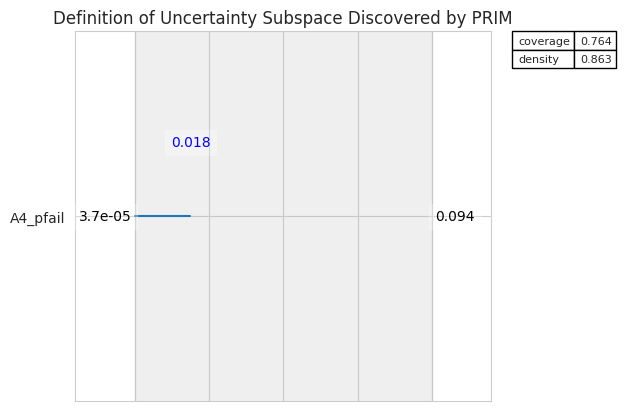

In [19]:
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Definition of Uncertainty Subspace Discovered by PRIM')
plt.savefig('img/vulnerability__prim_boundary.png')
plt.show()

Naturally, the most important uncertainties are the failure probabilities in our dike and in all upstream dike rings. The `pfail` variables actually predict likelihood of withstanding failure: that is, `A4_pfail=1` means that the dikes in Dike Ring 4 will never fail. 

Since we defined our PRIM search to seek a subset of the uncertainty space that leads to bad outcomes in Dike Ring 4 specifically, we have found a box that says such cases happen when _(a) dikes in Dike Ring 4 are very likely to fail_ and _(b) dikes upstream of us are relatively stronger and less likely to fail_ (if those dikes don't fail in the event of an extreme flooding event, it means all the additional water flow stays in the IJssel River until dikes finally break in Dike Ring 4; at that point, elevated water levels translate into more damage here).

We can plot all 40,000 scenarios in 2D slices of the uncertainty space, where the dimensions studied are the 4 `pfail`s that contribute to our PRIM box. Since it is hard to imagine a four-dimensional bounding box, let alone a 19-dimensional uncertainty space in the first place, this will help gain an intuitive understanding of the space of concern.

In [20]:
sns.set_style('white')

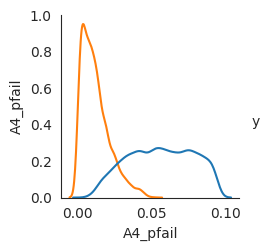

In [21]:
box1.show_pairs_scatter()
# show_pairs_scatter doesn't give enough vertical space to show suptitle
# plt.suptitle('Classified Scenario Runs by Key Uncertainty Values'
#              'with PRIM Box Superimposed', y=0.97)
plt.savefig('img/vulnerability__prim_pairs_scatter.png')
plt.show()

Here, it becomes clearer: scenarios of concern occur when our dike rings are _very_ likely to fail (the scenarios appear compressed against the wall of `A4_pfail=0`), and all the upstream dikes are anything _but_ very likely to fail. Interestingly, failure in Dike Ring 1 is the most restricted uncertainty after our own, likely because it is the most upstream. However, as indicated by the KDEs along the diagonal, there are some scenarios of concern that fall along all values of `A1_pfail`, even those outside our subspace. We do lose some exactlness of these scenarios of concern to have a convenient description in terms of the subspace.

We can capture the bounding box that defines our subspace in the uncertainty space as follows:

In [22]:
limits = box1.box_lims[best_box_idx]
limits

,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,A4_pfail,A4_Brate,A5_Bmax,A5_pfail,A5_Brate,discount_rate_0,discount_rate_1,discount_rate_2,A0_ID_flood_wave_shape
0,30.079064,0.369259,"{1.5, 10.0, 1.0}",30.048476,0.123509,"{1.5, 10.0, 1.0}",30.007795,0.247171,"{1.5, 10.0, 1.0}",30.063494,0.000037,"{1.5, 10.0, 1.0}",30.188075,0.000166,"{1.0, 10.0, 1.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}",0
1,349.970645,0.999886,"{1.5, 10.0, 1.0}",349.948428,0.999964,"{1.5, 10.0, 1.0}",349.975190,0.999860,"{1.5, 10.0, 1.0}",349.963706,0.017657,"{1.5, 10.0, 1.0}",349.980059,0.999943,"{1.0, 10.0, 1.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}",132


One could do further iterations of the PRIM algorithm using the selected box as a starting point. We played around with this process, but it didn't produce any more meaningful results than the first round of space peeling.

--------------------------

## 3. Filter, Sort, and Save Outputs

Having now defined a "region of concern" within the uncertainty space, we can select the subset of scenarios from our original design of experiments that falls within this space. Notably, this is different than selecting the subset of scenarios that fails our performance threshold; this will include some false positives (cases of lesser concern that fall in the box) and some false negatives (cases of high concern that are not included in the box). However, this is done because we can use this same bounding box later on to constrict the uncertainty space without even needing to know the results of the initial experiments. Since we will move forward with this PRIM box, we will filter the scenario list with it now.

In [23]:
# Create a new dataframe of experiments & their outcomes
# and track whether they fall outside the PRIM box boundary
combined_df = experiments.copy()
for key in outcomes:
    combined_df[key] = outcomes[key]

combined_df['Within Limit'] = True

print(combined_df.shape)
combined_df.head(3)

(15732, 67)


,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,...,A3_Expected_Annual_Damage,A3_Expected_Number_of_Deaths,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,A5_Expected_Annual_Damage,A5_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,Within Limit
0,245.492589,0.730879,1.5,103.700541,0.811144,1.5,212.666805,0.966618,1.5,51.327441,...,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,3.171744e+08,0.000000e+00,0.000000,True
1,262.554875,0.969102,10.0,280.377067,0.526979,10.0,187.570341,0.696104,1.0,64.726114,...,0.0,0.0,285240.387070,0.000016,8.062438e+06,0.000684,3.171744e+08,8.347678e+06,0.000700,True
2,275.708351,0.572317,1.0,265.693511,0.420025,1.5,121.947334,0.759597,10.0,272.023678,...,0.0,0.0,280561.829239,0.000016,4.829620e+07,0.004058,3.171744e+08,4.857676e+07,0.004074,True


In [24]:
# Apply PRIM constraint in each dimension
for idx, row in combined_df.iterrows():
    for unc in limits:
        if (type(limits.loc[0, unc]) == set):
            if row[unc] not in limits.loc[0, unc]:
                combined_df.at[idx, 'Within Limit'] = False
        else:
            if row[unc] < limits.loc[0, unc] or row[unc] > limits.loc[1, unc]:
                combined_df.at[idx, 'Within Limit'] = False

In [25]:
# Use new column to filter the rows, then drop this column
combined_df = combined_df[combined_df['Within Limit']]
combined_df = combined_df.drop(['Within Limit'], axis=1)
print(f'{combined_df.shape[0]} scenarios remain in the PRIM box.')

2864 scenarios remain in the PRIM box.


We have filtered down to almost 4000 scenarios. This makes sense, as it is roughly 10% of the set we started with (the scenarios that produced any damage to A4 under the status quo). 4000 scenarios is quite a few, so the next step will be to select a diverse, representative set of 3-5 of these scenarios that we can carry forward and use in our policy search. The generation of candidate sets and the assessment of set diversity will be done in [open_exploration__scenario_diversity_scoring.py](open_exploration__scenario_diversity_scoring.py). To support this set generation and filtering, we will save the filtered, combined experiments and outcomes DataFrame in sorted order by outcome 'A4 Expected Annual Damage'.

In [26]:
combined_df = combined_df.sort_values(by=ooi, ascending=False)
combined_df.head(3)

,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,...,A2_Expected_Number_of_Deaths,A3_Expected_Annual_Damage,A3_Expected_Number_of_Deaths,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,A5_Expected_Annual_Damage,A5_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
8374,130.939712,0.746688,1.0,254.050146,0.299472,1.0,81.734104,0.705162,1.0,126.542838,...,0.00000,3.586298e+06,0.000781,1.215047e+08,0.006472,0.000000e+00,0.000000,1.982227e+08,1.250910e+08,0.007253
12307,130.939712,0.746688,1.0,254.050146,0.299472,1.0,81.734104,0.705162,1.0,126.542838,...,0.00059,0.000000e+00,0.000000,1.214597e+08,0.006467,5.856854e+07,0.005999,1.686922e+08,1.851306e+08,0.013056
12200,65.974096,0.897180,10.0,60.535595,0.954783,1.0,169.459071,0.551625,10.0,260.615224,...,0.00000,3.472732e+06,0.000761,1.203532e+08,0.006534,0.000000e+00,0.000000,1.686922e+08,1.238260e+08,0.007294


In [27]:
output_filename = input_filename + '__prim_filtered.csv'
combined_df.to_csv(output_filename, index=True)